# Clustering Algorithms


The standard `sklearn` clustering suite has many different clustering classes alone.So what clustering algorithms should you be using? 

As with every question in data science and machine learning it depends on your data. A number of those classes in `sklearn` are specialised for certain tasks (such as co-clustering and bi-clustering, or clustering features instead data points). Obviously an algorithm specializing in text clustering is going to be the right choice for clustering text data, and other algorithms specialize in other specific kinds of data. 

Thus, if you know enough about your data, you can narrow down on the clustering algorithm that best suits that kind of data, or the sorts of important properties your data has, or the sorts of clustering you need done. 

All well and good, but what if you don't know much about your data? If, for example, you are 'just looking' and doing some exploratory data analysis (EDA) it is not so easy to choose a specialized algorithm. So, what algorithm is good for exploratory data analysis?

### Some basic concepts for a good EDA clustering

To start, lets' lay down some ground rules of what we need a good EDA clustering algorithm to do, then we can set about seeing how the algorithms available stack up.

* **Don't be wrong!**: If you are doing EDA you are trying to learn and gain intuitions about your data. In that case it is far better to get no result at all than a result that is wrong. Bad results lead to false intuitions which in turn send you down completely the wrong path. Not only do you not understand your data, you *misunderstand* your data. This means a good EDA clustering algorithm needs to conservative in int's clustering; it should be willing to not assign points to clusters; it should not group points together unless they really are in a cluster; this is true of far fewer algorithms than you might think.

* **Intuitive Parameters**: All clustering algorithms have parameters; you need some knobs to turn to adjust things. The question is: how do you pick settings for those parameters? If you know little about your data it can be hard to determine what value or setting a parameter should have. This means parameters need to be intuitive enough that you can hopefully set them without having to know a lot about your data.

* **Stable Clusters**: If you run the algorithm twice with a different random initialization, you should expect to get roughly the same clusters back. If you are sampling your data, taking a different random sample shouldn't radically change the resulting cluster structure (unless your sampling has problems). If you vary the clustering algorithm parameters you want the clustering to change in a somewhat stable predictable fashion.

* **Performance**: Data sets are only getting bigger. You can sub-sample (but see *stability*), but ultimately you need a clustering algorithm that can scale to large data sizes. A clustering algorithm isn't much use if you can only use it if you take such a small sub-sample that it is no longer representative of the data at large!

## Getting set up

If we are going to compare clustering algorithms we'll need a few things; 
first some libraries to load and cluster the data, and second some visualisation tools so we can look at the results of clustering. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
from sklearn import datasets, mixture
import time
from PIL import Image
from IPython.display import IFrame, Image, display
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

Next we need some data. 
To try to get a bit closer to the scenarios we face in the real world, we will use three different types of datasets: 

1. We will create a sample dataset that contains 4 clusters.
2. We will create another sample dataset that contains ring shaped clusters (So non-globular clusters)
3. We will use another dataset in the Data folder that contains some non-globular clusters and some noise data.

So that we can actually visualize clusterings, the dataset is two dimensional; this is not something we expect from real-world data where you generally can't just visualize and see what is going on.

In [3]:
np.random.seed(844)
clust1 = np.random.normal(5, 2, (1000,2))
clust2 = np.random.normal(15, 3, (1000,2))
clust3 = np.random.multivariate_normal([17,3], [[1,0],[0,1]], 1000)
clust4 = np.random.multivariate_normal([2,16], [[1,0],[0,1]], 1000)
dataset1 = np.concatenate((clust1, clust2, clust3, clust4))

# we take the first array as the second array has the cluster labels
dataset2 = datasets.make_circles(n_samples=1000, factor=.5, noise=.05)[0]

dataset3 = np.load('clustering_data/clusterable_data.npy')

So let's have a look at the data and see what we have.

In [4]:
dataset_list = [dataset1,dataset2,dataset3]

In [5]:
for data in dataset_list:
    print(data.shape)

(4000, 2)
(1000, 2)
(2309, 2)


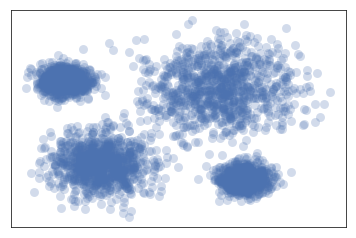

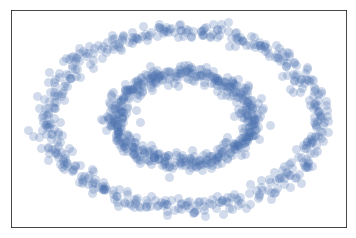

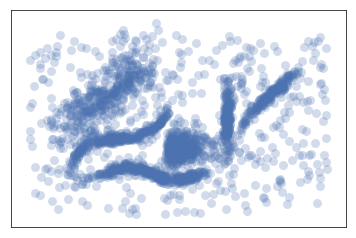

<Figure size 432x288 with 0 Axes>

In [6]:
for data in dataset_list:
    plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.figure()

It's messy, but there are certainly some clusters that you can pick out by eye; determining the exact boundaries of those clusters is harder of course, but we can hope that our clustering algorithms will find at least some of those clusters. So, on to testing ...

## Testing Clustering Algorithms

To start let's set up a little utility function to do the clustering and plot the results for us. We can time the clustering algorithm while we're at it and add that to the plot since we do care about performance.

In [7]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

Before we try doing the clustering, there are some things to keep in mind as we look at the results.

* In real use cases we *can't* look at the data and realise points are not really in a cluster; we have to take the clustering algorithm at its word.
* These are small toy datasets, so 

On to the clustering algorithms.

## K-Means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere 

Basic concepts: The algorithm iteratively group points based on their distance from the cluster centers. Here are the steps

1. randomly select k data points from D as the initial cluster centers;
2. Start loop;
3. re/assign each data points to the cluster to which the object is the most similar (i.e. which is more near based upon the euclidean distance measure),based on the mean value of the objects in the cluster;
4. update the cluster means, that is, calculate the new mean value of the data points for each cluster;
5. go to loop until no change in cluster means

Let's look at an animation to understand this:

In [8]:
IFrame(src='http://shabal.in/visuals/kmeans/2.html', width=900, height=500)


Pros:
* Very efficient and fast to run. Can handle huge datasets also very well.

Cons:
* The first is that it isn't a clustering algorithm, it is a partitioning algorithm. That is to say K-means doesn't 'find clusters' it partitions your dataset into as many (assumed to be globular) chunks as you ask for by attempting to minimize intra-partition distances. 
* That leads to the second problem: you need to specify exactly how many clusters you expect. If you know a lot about your data then that is something you might expect to know. 
* Finally K-Means is also dependent upon initialization; give it multiple different random starts and you can get multiple different clusterings. This does not engender much confidence in any individual clustering that may result.

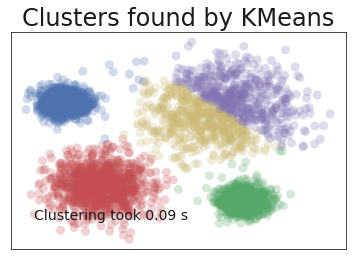

In [9]:
plot_clusters(dataset1, cluster.KMeans, (), {'n_clusters':5})

## Exercise time:

### Individual exercise:

Try running our K-means algorithm on the other 2 datasets. 
* Explore how it performs on those datasets with changing parameters.
* Explore the results by running it a couple of times for the same parameters.

### Small group exercise:

Get into a group of 2 and discuss how does our K-means algorithm hold on our 4 initial concepts:

* **Don't be wrong!**:
* **Intuitive parameters**:
* **Stability**:
* **Performance**:

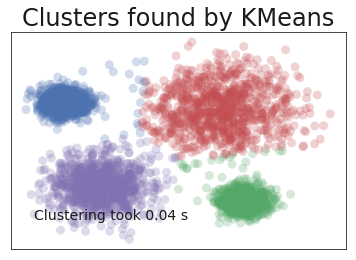

In [10]:
plot_clusters(dataset1, cluster.KMeans, (), {'n_clusters':4})

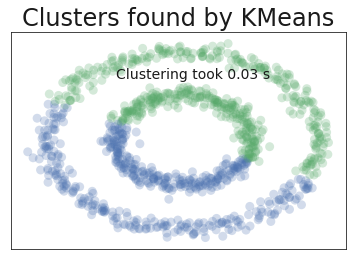

In [11]:
plot_clusters(dataset2, cluster.KMeans, (), {'n_clusters':2})

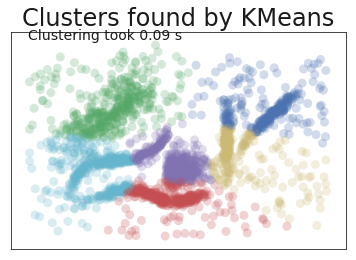

In [12]:
plot_clusters(dataset3, cluster.KMeans, (), {'n_clusters':6})

We see some interesting results. 
First, the assumption of perfectly globular clusters means that the natural clusters have been spliced and clumped into various more globular shapes. 

Worse, the noise points get lumped into clusters as well: in some cases, due to where relative cluster centers ended up, points very distant from a cluster get lumped in. 

Having noise pollute your clusters like this is particularly bad in an EDA world since they can easily mislead your intuition and understanding of the data. On a more positive note we completed clustering very quickly indeed, so at least we can be wrong quickly.

So, in summary, here's how K-Means seems to stack up against our concepts:
* **Don't be wrong!**: K-means is going to throw points into clusters whether they belong or not; it also assumes you clusters are globular. K-Means scores very poorly on this point.
* **Intuitive parameters**: If you have a good intuition for how many clusters the dataset your exploring has then great, otherwise you might have a problem.
* **Stability**: Hopefully the clustering is stable for your data. Best to have many runs and check though.
* **Performance**: This is K-Means big win. It's a simple algorithm and with the right tricks and optimizations can be made exceptionally efficient. There are few algorithms that can compete with K-Means for performance. If you have truly huge data then K-Means might be your only option.

## Mean Shift

Basic concepts:

* Mean shift is another option if you don't want to have to specify the number of clusters.
* It is centroid based, like K-Means and affinity propagation, but can return clusters instead of a partition. 
* The underlying idea of the Mean Shift algorithm is that there exists some probability density function from which the data is drawn, and tries to place centroids of clusters at the maxima of that density function. 
* In other words, locate the density function maxima (mean shift algorithm) and then assign points to the nearest maxima. 
* In that sense, it shares some similarities with k-means (the density maxima correspond to the centroids in the latter). 
* No of clusters are not required, instead, the algorithm relies on a bandwidth parameter, which simply determines the size of neighbourhood over which the density will be computed. A small bandwidth could generate excessive clusters, while a high value could erroneously combine multiple clusters. 
* Luckily, sklearn includes an estimate_bandwidth function. It uses the k-nearest neighbours (kNN) algorithm to determine an optimal bandwidth value. That makes it even easier than k-means to implement.

#### How it works:
* Intuitively, cluster centers are initially mapped onto the dataset randomly (like k-means). 
* Around each centre is a ball (the radius of which is determined by the bandwidth), where the density equates to the number of points inside each ball. 
* The centre of the ball is iteratively nudged towards regions of higher density by shifting the centre to the mean of the points within the ball (hence the name). 
* This process is repeated until balls exhibit little movement. When multiple balls overlap, the ball containing the most points is preserved. 
* Observations are then clustered according to their ball.

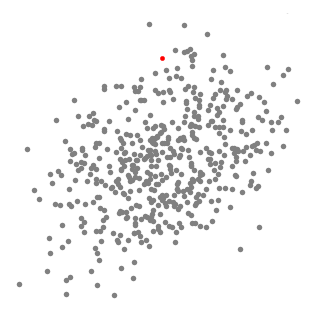

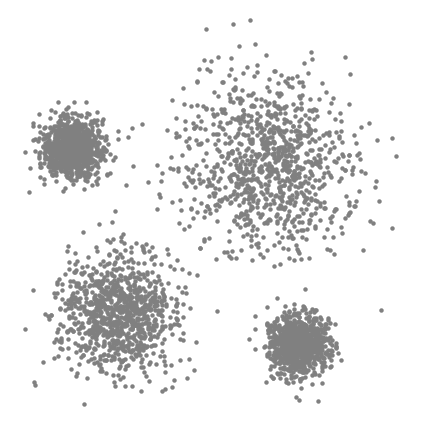

In [78]:
display(Image(filename="clustering_data/mean_shift_0.gif.png"),Image(filename="clustering_data/mean_shift_tutorial.gif.png"))

## Exercise time:

### Individual exercise:

Try running the Mean-shift algorithm on our datasets. 
* Explore how it performs on those datasets with changing parameters. (We will use estimate_bandwidth later)
* Explore the results by running it a couple of times for the same parameters.

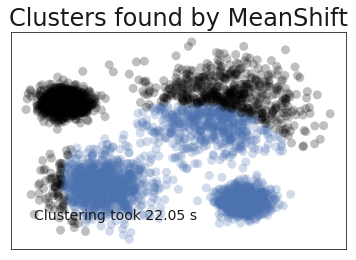

In [15]:
plot_clusters(dataset1, cluster.MeanShift, (10,), {'cluster_all':False})

### Small group exercise:

Get into a group of 3-4 and discuss how does our K-means algorithm hold on our 4 initial concepts:

* **Don't be wrong!**:
* **Intuitive parameters**:
* **Stability**:
* **Performance**:

Pros and Cons:
* Interestingly, the number of clusters is not required for its implementation and, as it’s density based, it can detect clusters of any shape. Not only globular. 
* Parameter estimation is very easy, mainly after the estimate_bandwidth function.
* But there is an important note, in practice this function doesn't always give the most optimal value. You still would like to explore some other values yourself. 
* In fact, according to the sklearn documentation, the estimate_bandwidth function scales particularly badly.

We will use estimate_bandwidth, to get the bandwidth parameter.

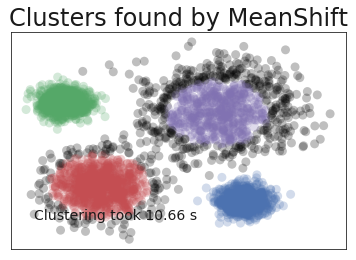

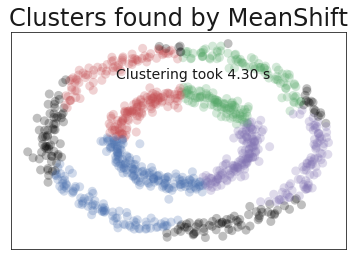

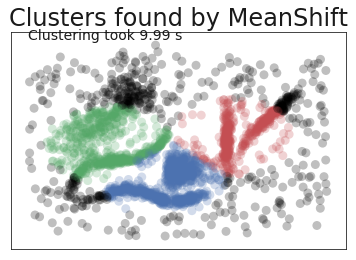

<Figure size 432x288 with 0 Axes>

In [16]:
for data in dataset_list:
    bandwidth = cluster.estimate_bandwidth(data,
                                quantile=.2, n_samples=500)
    plot_clusters(data, cluster.MeanShift, (bandwidth,), {'cluster_all':False})
    plt.figure()

We at least aren't polluting our clusters with as much noise, but we certainly have dense regions left as noise and clusters that run across and split what seem like natural clusters. Thus while Mean Shift had good promise, and is certainly better than K-Means, it's still short of our criterias.

How does Mean Shift fare against our criteria?

* **Don't be wrong!**: Mean Shift doesn't cluster every point, but it still aims for globular clusters, and in practice it can return less than ideal results (see below for example). Without visual validation it can be hard to know how wrong it may be.
* **Intuitive parameters**: Mean Shift has more intuitive and meaningful parameters; this is certainly a strength.
* **Stability**: Mean Shift results can vary a lot as you vary the bandwidth parameter (which can make selection more difficult than it first appears. It also has a random initialisation, which means stability under runs can vary (if you reseed the random start).
* **Performance**: While Mean Shift has good scalability in principle (using ball trees) in practice the sklearn implementation is slow; this is a serious weak point for Mean Shift.

### Bonus Fun Exercise

(-0.5, 618.5, 429.5, -0.5)

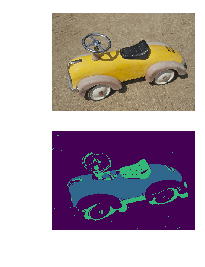

In [88]:
import PIL.Image
image = Image.open('clustering_data/car_toy_data.png')
image = np.array(image)

#Need to convert image into feature array based
#on rgb intensities
flat_image=np.reshape(image, [-1, 4])
 
#Estimate bandwidth
bandwidth2 = cluster.estimate_bandwidth(flat_image,
                                quantile=.2, n_samples=500)
ms = cluster.MeanShift(bandwidth2, bin_seeding=True)
ms.fit(flat_image)
labels=ms.labels_
 
# Plot image vs segmented image
plt.figure(2)
plt.subplot(2, 1, 1)
plt.imshow(image)
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(np.reshape(labels, [430,619]))
plt.axis('off')

I think the picture speaks for itself.